[Go to this directory index](./)

Contents
  - [Optimization method 2.5 parametric studies¶](#Optimization-method-2.5-parametric-studies)
    - [Setup¶](#Setup)
      - [Strategy¶](#Strategy)
    - [Parametric study across T_heat_reject¶](#Parametric-study-across-T_heat_reject)
      - [Step one¶](#Step-one)
      - [Postprocessing - Learning pandas and visualization¶](#Postprocessing---Learning-pandas-and-visualization)
      - [Step Two: Parameter sweep on output, optimize cost¶](#Step-Two:-Parameter-sweep-on-output,-optimize-cost)
  - [Scratch work¶](#Scratch-work)

# Optimization method 2.5 parametric studies

Previously, I obtained reasonable convergence on optima using a two-step strategy: first, simply enforce feasibility and optimize cooling output without regard to cost; then for any given cooling output goal less than the maximum, enforce that as a constraint and optimize system cost (from size and flow parameters). With some art in selecting constraint functions, I implemented this using the COBYLA optimization routine.

Since that method can be made to work, let's do a parametric study in two parameters: temperature for heat rejection (T) and cost (UA). For each heat reject temperature, we will determine the maximum cooling (Q_max), then build a cost vs cooling curve. The data should form a surface of points (T,UA,Q). We can also visualize that surface by projecting and plotting isolines, for example, isolines of UA on a (T,Q) plot.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy
from numpy import array, inf, nan
import pandas
from IPython.display import HTML, SVG, clear_output

In [3]:
#matplotlib.use('svg')
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [4]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

In [5]:
import ammonia1
import system_aqua1
import scipy.optimize

In [6]:
def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

def barrier1(c, length_scale):
    """The domain for B is the feasible set only.
    We want B large near boundary, but small elsewhere.
    Feasible means c > 0 and g < 0. Please input c.
    """
    g = numpy.negative(c)
    b = numpy.exp(g / length_scale)
    return numpy.sum(b)

def decay1(step_number, initial_value = 1., rate = 1.):
    """A decaying function to scale barrier functions.
    step_number: as this increases, I decay.
    initial_value: value when step_number = 0.
    decay_rate: how fast to decay.
    """
    # Magnitude tends to zero, slowly
    mu_B = initial_value * numpy.exp(-rate * step_number)
    return mu_B        

def penalty1(c, length_scale):
    """We want P = 0 for feasible, P > 0 elsewhere
    Feasible means c > 0 and g < 0.
    """
    g = numpy.negative(c)
    g = saturate(g,bottom=0,top=numpy.inf)
    p = (g / length_scale)**2
    return numpy.sum(p)

def grow1(step_number, initial_value = 1., rate = 1.):
    """A growing function to scale penalty functions."""
    # Magnitude tends to infinite, bit more quickly
    mu_P = initial_value * numpy.exp(rate * step_number)
    return mu_P


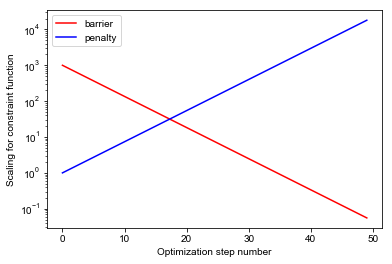

In [16]:
step_number = numpy.arange(50)
mu_B = decay1(step_number,initial_value=1000,rate=0.2)
mu_P = grow1(step_number,initial_value=1,rate=0.2)
plt.close('all')
plt.figure()
plt.semilogy(step_number,mu_B,'r',label='barrier')
plt.semilogy(step_number,mu_P,'b',label='penalty')
plt.xlabel('Optimization step number')
plt.ylabel('Scaling for constraint function')
plt.legend()
plt.show()

### Strategy
An extension of a previous idea, kind of the dual problem -- Perform optimization in two steps: first with no constraint on UA (cost) to determine maximum Q (output). Then for each Q in a set of lesser values, optimize with respect to cost. This will deliver an optimal cost vs output curve.

For the first step, since we are not interested in UA, we can be less strict with the constraints on heat exchange feasibility. Specifically, we can impose them via penalty constraints instead of barrier constraints.

In [8]:
class Problem_2_5_A:
    def __init__(self, bdry, mu=0.1):
        self.bdry = bdry
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        # print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T]                        
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [deltaT - 0.01
                         for name, deltaT, epsilon, UA, Qhx in sys.data]
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except KeyboardInterrupt as e:
            raise e
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [9]:
class Problem_2_5_B:
    def __init__(self, bdry, Q_goal, mu=0.1):
        self.bdry = bdry
        self.Q_goal = Q_goal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective_raw(self, xC):
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            UA = sys.totalUA
        except:
            UA = numpy.nan
        return UA

        
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        #print(xC,flush=True)
        UA,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                       + [deltaT
                          for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [ch.Q_evap - self.Q_goal]
            P = mu_P * penalty1(penalties,1)
            
            UA = sys.totalUA
        except KeyboardInterrupt as e:
            raise e
        except:
            UA = numpy.inf
        
        # print(self.n_calls, step_number, UA, B, P, "\n", flush=True)
        return UA + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

## Parametric study across T_heat_reject

In [56]:
def display_result(x):
    try:
        print("X = ")
        display(x)
        ch = system_aqua1.makeChiller(x)
        sys = system_aqua1.System(bdry, ch)
        display(sys)
    except KeyboardInterrupt as e:
        raise e
    except Exception as e:
        display(e)

In [7]:
t_heat_reject_range = 273.15 + numpy.arange(20,61,5)

In [147]:
opts = [None] * len(t_heat_reject_range)

### Step one

In [24]:
for i,T_heat_reject in enumerate(t_heat_reject_range):
    if opts[i] is None:
        print("Case {}, T_heat_reject = {} K".format(i, T_heat_reject))
        rT = T_heat_reject
        xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_A(bdry)
        x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])
        
        P.n_calls = 7*30
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("First pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*40
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("Second pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*50
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.01})
        display("Third pass and we have this ... ")
        display_result(x)

        opts[i] = opt

Case 0, T_heat_reject = 293.15 K


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


211 30.0 29.3426607866 8.88824099481e-197 2045.94701491 

Note: Absorber inlet is subcooled
212 30.0 88.0279823597 8.88824099481e-197 2045.95661909 

Note: Absorber inlet is subcooled
213 30.0 88.2479969814 9.83458747162e-196 1914.60615648 

Note: Absorber inlet is subcooled
214 30.0 88.1631796043 1.01618763273e-196 1822.45823884 

Note: Absorber inlet is subcooled
215 30.0 88.1631796043 7.57316972933e-196 1822.45823884 

Note: Absorber inlet is subcooled
216 30.0 87.9564109646 1.14805121731e-197 1280.0294175 

Note: Absorber inlet is subcooled
217 30.0 88.005971887 1.14805121731e-197 1299.88010459 

Note: Absorber inlet is subcooled
218 31.0 93.8320709629 1.33399233081e-219 1108.62680934 

Note: Absorber inlet is subcooled
219 31.0 98.1737330263 6.74568544905e-221 997.074130878 

Note: Absorber inlet is subcooled
220 31.0 100.308567159 9.12443222761e-220 958.766363235 

Note: Absorber inlet is subcooled
221 31.0 71.4845744468 9.15266871564e-220 933.779022092 

Note: Absorber inlet is 

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89591,0.953251,8.95054,180.194
rect,6.16349,0.77556,1.02236,9.72029
abs,-0.000194433,1.00002,inf,175.826
cond,1.54541,0.970924,35.4646,123.273
evap,0.0363772,0.995287,89.6341,128.423
total,0,0,inf,0


Note: Absorber inlet is subcooled
281 40.0 128.423482186 0.0 16.914530482 

Note: Absorber inlet is subcooled
282 40.0 186.545908554 0.0 2178629.81334 

Note: Absorber inlet is subcooled
283 40.0 128.744907878 0.0 1390.18056358 

Note: Absorber inlet is subcooled
284 40.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 127.996758765 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 128.37139887 0.0 0.208133304003 

Note: Absorber inlet is subcooled
288 41.0 70.232060958 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 129.379905687 0.0 6.87637500976 

Note: Absorber inlet is subcooled
290 41.0 155.463107725 0.0 565360.303557 

Note: Absorber inlet is subcooled
291 41.0 113.791554212 0.0 0.0 

Note: Absorber inlet is subcooled
292 41.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 128.335723806 0.0 0.241722009911 

Note: Absorber inlet is subcooled
294 41.0 128.335240285 0.0

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89387,0.953227,9.0128,180.745
rect,5.50136,0.809975,1.19735,10.2417
abs,0.0117575,0.999228,396.56,176.371
cond,1.62968,0.970423,34.215,123.112
evap,0.0158304,0.997949,103.544,128.777
total,0,0,544.529,0


Note: Absorber inlet is subcooled
351 50.0 128.776871008 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 134.583452607 0.0 381321.209955 

Note: Absorber inlet is subcooled
353 50.0 128.809115981 0.0 119.858891256 

Note: Absorber inlet is subcooled
354 50.0 128.764231518 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 128.776871008 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 128.746632988 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 128.784280347 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 122.977355274 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 128.909616822 0.0 0.0 

Note: Absorber inlet is subcooled
360 51.0 128.917186587 0.0 7.15431674744 

Note: Absorber inlet is subcooled
361 51.0 129.472643992 0.0 4192.80069994 

Note: Absorber inlet is subcooled
362 51.0 128.912784123 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 128.929891676 0.0 54.5211387278 

Note: Absorber inlet is subcooled
364 51.0 128.912784123 0.0 0.0 

Note: Absorb

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89387,0.953227,9.0128,180.745
rect,5.50136,0.809975,1.19735,10.2417
abs,0.0117575,0.999228,396.56,176.371
cond,1.62968,0.970423,34.215,123.112
evap,0.0158304,0.997949,103.544,128.777
total,0,0,544.529,0


Case 1, T_heat_reject = 298.15 K
Note: Absorber inlet is subcooled
211 30.0 24.5883547239 1.01305231855e-250 3156.278929 

Note: Absorber inlet is subcooled
212 30.0 73.7650641718 1.01305231855e-250 3156.2910157 

Note: Absorber inlet is subcooled
213 30.0 73.9673270767 1.20595045745e-249 3144.35934709 

Note: Absorber inlet is subcooled
214 30.0 73.8724667435 1.18138325969e-250 2961.13902246 

Note: Absorber inlet is subcooled
215 30.0 73.8724667435 8.80429524319e-250 2961.13902246 

Note: Absorber inlet is subcooled
216 30.0 73.6861850466 1.29308121156e-251 2157.21304698 

Note: Absorber inlet is subcooled
217 30.0 73.7452878644 1.29308121156e-251 2208.13157745 

Note: Absorber inlet is subcooled
218 31.0 76.3946869366 1.40969493378e-279 1978.41316719 

Note: Absorber inlet is subcooled
219 31.0 78.0998625965 5.41819018621e-281 1878.72104919 

Note: Absorber inlet is subcooled
220 31.0 102.263696544 7.24475114495e-281 1902.88874034 

Note: Absorber inlet is subcooled
221 31.0 71.3959

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.72568,0.942974,13.5578,188.286
rect,6.32268,0.798931,1.25848,12.9269
abs,0.0658155,0.996278,151.077,181.903
cond,1.72475,0.968174,33.1259,121.225
evap,0.00852878,0.998883,113.698,127.462
total,0,0,312.717,0


Note: Absorber inlet is subcooled
281 40.0 127.461974329 0.0 0.352282771288 

Note: Absorber inlet is subcooled
282 40.0 176.053323473 0.0 1411320.49389 

Note: Absorber inlet is subcooled
283 40.0 127.812999795 0.0 2424.28720848 

Note: Absorber inlet is subcooled
284 40.0 127.295013964 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 127.295013964 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 126.972873178 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 127.399272088 0.0 0.0 

Note: Absorber inlet is subcooled
288 41.0 78.8315253996 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 127.751533304 0.0 0.0 

Note: Absorber inlet is subcooled
290 41.0 127.832396933 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 152.099213946 0.0 446705.172014 

Note: Absorber inlet is subcooled
292 41.0 127.744197618 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 103.56980027 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 127.832396933 0.0 0.0 

Note: Absorber inlet i

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.59327,0.944479,13.8375,189.054
rect,5.69765,0.824097,1.42883,13.4535
abs,0.0532557,0.996993,162.557,182.646
cond,1.80619,0.967714,32.0739,121.142
evap,0.0295339,0.996154,93.0342,127.878
total,0,0,302.931,0


Note: Absorber inlet is subcooled
351 50.0 127.877756489 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 132.73287088 0.0 239926.242178 

Note: Absorber inlet is subcooled
353 50.0 127.912957378 0.0 0.0 

Note: Absorber inlet is subcooled
354 50.0 127.896200962 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 127.912957378 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 127.880609233 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 127.923414695 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 123.066566817 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 130.351981593 0.0 84614.5291692 

Note: Absorber inlet is subcooled
360 51.0 127.923414514 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 125.494929393 0.0 0.0 

Note: Absorber inlet is subcooled
362 51.0 127.927603211 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 130.356249609 0.0 84926.8477442 

Note: Absorber inlet is subcooled
364 51.0 127.927603211 0.0 0.0 

Note: Absorber inlet is subcooled

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.59327,0.944479,13.8375,189.054
rect,5.69765,0.824097,1.42883,13.4535
abs,0.0532557,0.996993,162.557,182.646
cond,1.80619,0.967714,32.0739,121.142
evap,0.0295339,0.996154,93.0342,127.878
total,0,0,302.931,0


Case 2, T_heat_reject = 303.15 K
Note: Absorber inlet is subcooled
211 30.0 19.9331400856 1.55372380346e-306 0.0 

Note: Absorber inlet is subcooled
212 30.0 59.7994202567 1.55372380346e-306 0.0 

Note: Absorber inlet is subcooled
213 30.0 59.99131292 1.98845108119e-305 0.0 

Note: Absorber inlet is subcooled
214 30.0 59.8837069901 1.82759732759e-306 0.0 

Note: Absorber inlet is subcooled
215 30.0 59.99131292 1.48189931183e-304 0.0 

Note: Absorber inlet is subcooled
216 30.0 59.8182702399 2.1117748481e-306 0.0 

Note: Absorber inlet is subcooled
217 30.0 60.0605796362 1.98845108119e-305 0.0 

Note: Absorber inlet is subcooled
218 31.0 100.103386032 0.0 0.0 

Note: Absorber inlet is subcooled
219 31.0 140.148954111 0.0 3382.59617044 

Note: Absorber inlet is subcooled
220 31.0 86.0536995635 0.0 0.0 

Note: Absorber inlet is subcooled
221 31.0 100.13550747 0.0 0.0 

Note: Absorber inlet is subcooled
222 31.0 94.8860201301 0.0 0.0 

Note: Absorber inlet is subcooled
223 31.0 100.1272660

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.7376,0.928577,27.6219,203.176
rect,7.8445,0.770793,1.24269,15.7568
abs,0.249032,0.987074,99.8262,194.275
cond,1.393,0.968503,38.0245,124.056
evap,0.0103254,0.998679,110.891,130.441
total,0,0,277.606,0


Note: Absorber inlet is subcooled
281 40.0 130.441454491 0.0 0.0 

Note: Absorber inlet is subcooled
282 40.0 170.52307329 0.0 17485258.3814 

Note: Absorber inlet is subcooled
283 40.0 130.858162717 0.0 2509.1821583 

Note: Absorber inlet is subcooled
284 40.0 130.208348306 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 130.441454491 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 130.066125676 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 130.591384769 0.0 12.1603681215 

Note: Absorber inlet is subcooled
288 41.0 90.3597946504 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 110.400619974 0.0 0.0 

Note: Absorber inlet is subcooled
290 41.0 130.498596166 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 130.480055926 0.0 0.0 

Note: Absorber inlet is subcooled
292 41.0 140.512398717 0.0 73275.3669528 

Note: Absorber inlet is subcooled
293 41.0 130.498703194 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 120.482074698 0.0 0.0 

Note: Absorber inlet is 

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.73849,0.92856,28.0021,203.826
rect,7.85109,0.770432,1.24671,15.7945
abs,0.232539,0.987928,103.252,194.893
cond,1.36067,0.968558,38.5732,124.453
evap,0.0111087,0.998583,109.721,130.844
total,0,0,280.795,0


Note: Absorber inlet is subcooled
351 50.0 130.844130436 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 134.851967143 0.0 186185.771331 

Note: Absorber inlet is subcooled
353 50.0 130.885901065 0.0 420.805617671 

Note: Absorber inlet is subcooled
354 50.0 130.821146007 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 130.844130436 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 130.80645533 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 130.859181492 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 126.850802513 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 130.861919943 0.0 0.0 

Note: Absorber inlet is subcooled
360 51.0 130.871341085 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 132.875566427 0.0 58858.8734849 

Note: Absorber inlet is subcooled
362 51.0 130.871341498 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 128.867145045 0.0 0.0 

Note: Absorber inlet is subcooled
364 51.0 130.871341498 0.0 0.0 

Note: Absorber inlet is subcooled

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.73849,0.92856,28.0021,203.826
rect,7.85109,0.770432,1.24671,15.7945
abs,0.232539,0.987928,103.252,194.893
cond,1.36067,0.968558,38.5732,124.453
evap,0.0111087,0.998583,109.721,130.844
total,0,0,280.795,0


Case 3, T_heat_reject = 308.15 K
Note: Absorber inlet is subcooled
211 30.0 15.2618651202 0.0 0.0 

Note: Absorber inlet is subcooled
212 30.0 45.7855953606 0.0 0.0 

Note: Absorber inlet is subcooled
213 30.0 45.9716522196 0.0 0.0 

Note: Absorber inlet is subcooled
214 30.0 45.8534097791 0.0 0.0 

Note: Absorber inlet is subcooled
215 30.0 45.9716522196 0.0 0.0 

Note: Absorber inlet is subcooled
216 30.0 45.8072772852 0.0 0.0 

Note: Absorber inlet is subcooled
217 30.0 46.0525326126 0.0 0.0 

Note: Absorber inlet is subcooled
218 31.0 76.7573512575 0.0 0.0 

Note: Absorber inlet is subcooled
219 31.0 107.465735928 0.0 0.0 

Note: Absorber inlet is subcooled
220 31.0 138.177666994 0.0 1463186.64115 

Note: Absorber inlet is subcooled
221 31.0 107.58959751 0.0 0.0 

Note: Absorber inlet is subcooled
222 31.0 93.9176322107 0.0 0.0 

Note: Absorber inlet is subcooled
223 31.0 107.698969248 0.0 0.0 

Note: Absorber inlet is subcooled
224 31.0 99.4908168 0.0 0.0 

Note: Absorber inlet is

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.0453529,0.998956,124.808,181.433
rect,7.93188,0.8057,1.15552,17.1645
abs,2.26958,0.891645,29.7156,171.221
cond,2.40825,0.969135,24.6252,102.215
evap,1.29735,0.983616,30.0293,108.549
total,0,0,210.333,0


Note: Absorber inlet is subcooled
281 40.0 108.548861742 0.0 0.0 

Note: Absorber inlet is subcooled
282 40.0 139.371601696 0.0 22928228.5407 

Note: Absorber inlet is subcooled
283 40.0 108.986261483 0.0 0.0 

Note: Absorber inlet is subcooled
284 40.0 108.709576827 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 108.986261483 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 108.599580147 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 109.175241593 0.0 403.759633968 

Note: Absorber inlet is subcooled
288 41.0 78.0393183353 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 110.074768591 0.0 32146.4013095 

Note: Absorber inlet is subcooled
290 41.0 109.037117157 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 112.907151088 0.0 479888.156385 

Note: Absorber inlet is subcooled
292 41.0 101.297046998 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 109.091815409 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 116.837878554 0.0 1935380.98419 

Note: Absorb

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.01694,0.999611,181.239,182.083
rect,7.9359,0.804712,1.16013,17.1639
abs,2.22358,0.89363,30.2169,171.88
cond,2.3679,0.969199,24.9814,102.787
evap,1.15053,0.983837,31.798,109.131
total,0,0,269.395,0


Note: Absorber inlet is subcooled
351 50.0 109.130679142 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 112.22899717 0.0 4581228.20733 

Note: Absorber inlet is subcooled
353 50.0 109.174442408 0.0 0.0 

Note: Absorber inlet is subcooled
354 50.0 109.14680683 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 109.174442408 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 109.135742354 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 109.193339548 0.0 8.05277994397 

Note: Absorber inlet is subcooled
358 51.0 106.074881871 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 109.723655898 0.0 183581.247215 

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


360 51.0 108.399552246 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 109.179925909 0.0 0.0 

Note: Absorber inlet is subcooled
362 51.0 109.184590739 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 109.18942866 0.0 0.0 

Note: Absorber inlet is subcooled
364 51.0 109.964610554 0.0 379523.649691 

Note: Absorber inlet is subcooled
365 52.0 109.189427615 0.0 0.0 

Note: Absorber inlet is subcooled
366 52.0 108.414401817 0.0 0.0 

Note: Absorber inlet is subcooled
367 52.0 109.18942866 0.0 0.0 

Note: Absorber inlet is subcooled
368 52.0 109.964610553 0.0 512303.416904 

Note: Absorber inlet is subcooled
369 52.0 109.577018958 0.0 124238.362963 

Note: Absorber inlet is subcooled
370 52.0 109.189428607 0.0 0.0 

Note: Absorber inlet is subcooled
371 52.0 108.801876609 0.0 0.0 

Note: Absorber inlet is subcooled
372 53.0 109.190594821 0.0 0.0 

Note: Absorber inlet is subcooled
373 53.0 109.578189255 0.0 168886.818647 

Note: Absorber inlet is subcooled
374 53.0 108.99681663 0.

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.01694,0.999611,181.239,182.083
rect,7.9359,0.804712,1.16013,17.1639
abs,2.22358,0.89363,30.2169,171.88
cond,2.3679,0.969199,24.9814,102.787
evap,1.15053,0.983837,31.798,109.131
total,0,0,269.395,0


Case 4, T_heat_reject = 313.15 K
Note: Absorber inlet contains some vapor.
211 30.0 10.4857914382 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 31.4573743146 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 31.6407202325 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 31.508103866 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 31.6407202325 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 31.4819859795 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 31.7349644758 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 52.8963283921 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 74.063061542 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 95.2351132483 0.0 717020.165803 

Note: Absorber inlet contains some vapor.
221 31.0 74.1849849635 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 64.7950391871 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 74.29035

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0195754,0.999461,173.938,139.747
rect,7.96979,0.838605,0.821906,15.4784
abs,4.9484,0.768336,14.4515,130.186
cond,3.89507,0.966713,13.5225,70.1235
evap,3.28594,0.983425,14.4718,75.2979
total,0,0,217.206,0


Note: Absorber inlet contains some vapor.
281 40.0 75.2979170048 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 96.5756559021 0.0 11700695.3672 

Note: Absorber inlet contains some vapor.
283 40.0 75.7308063918 0.0 2.74953196909 

Note: Absorber inlet contains some vapor.
284 40.0 74.985795528 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 75.2979170048 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 74.9232824764 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 75.519531446 0.0 1188.39059772 

Note: Absorber inlet contains some vapor.
288 41.0 54.0201620102 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 64.6590379116 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 75.3380115668 0.0 4.73844041144 

Note: Absorber inlet contains some vapor.
291 41.0 75.24388268 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 79.2909936285 0.0 546400.765493 

Note: Absorber inlet contains some vapor.
293 41.0 75.

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0140486,0.999627,199.122,139.839
rect,7.97204,0.83858,0.822627,15.484
abs,4.93363,0.768966,14.4874,130.278
cond,3.8949,0.966702,13.5321,70.1865
evap,3.27887,0.983431,14.5015,75.3662
total,0,0,242.465,0


Note: Absorber inlet contains some vapor.
351 50.0 75.3661533523 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 77.4957353342 0.0 2316302.14598 

Note: Absorber inlet contains some vapor.
353 50.0 75.4094371112 0.0 0.0 

Note: Absorber inlet contains some vapor.
354 50.0 75.3782526937 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 75.4094371112 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 75.3719392518 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 75.4316109817 0.0 152.415547728 

Note: Absorber inlet contains some vapor.
358 51.0 73.2786306714 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 75.4133268502 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 75.946232213 0.0 194381.547406 

Note: Absorber inlet contains some vapor.
361 51.0 75.4133287505 0.0 0.0 

Note: Absorber inlet contains some vapor.
362 51.0 74.8805343356 0.0 0.0 

Note: Absorber inlet contains some vapor.
363 51.0 75.4180168876 0.0 0.

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0140486,0.999627,199.122,139.839
rect,7.97204,0.83858,0.822627,15.484
abs,4.93363,0.768966,14.4874,130.278
cond,3.8949,0.966702,13.5321,70.1865
evap,3.27887,0.983431,14.5015,75.3662
total,0,0,242.465,0


Case 5, T_heat_reject = 318.15 K
Note: Absorber inlet contains some vapor.
211 30.0 5.51897762569 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 16.5569328771 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 16.7399188614 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 16.5897806846 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 16.7399188614 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 16.5846106716 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 16.8499097874 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 28.0928402944 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 39.3466966037 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 50.6112426796 0.0 103330.977087 

Note: Absorber inlet contains some vapor.
221 31.0 39.4680768878 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 34.5281457496 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 39.570

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0109519,0.999918,211.237,99.8247
rect,7.99233,0.865834,0.483795,11.5475
abs,4.93982,0.70365,12.1247,92.7155
cond,5.27092,0.965175,6.66969,40.0875
evap,5.17436,0.98324,6.84364,43.5767
total,0,0,237.359,0


Note: Absorber inlet contains some vapor.
281 40.0 43.5767168869 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 54.9533948323 0.0 3616892.60374 

Note: Absorber inlet contains some vapor.
283 40.0 44.0442017249 0.0 252.383863267 

Note: Absorber inlet contains some vapor.
284 40.0 43.1943707512 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 43.5767168869 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 43.1800087709 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 43.8565812937 0.0 2323.0374273 

Note: Absorber inlet contains some vapor.
288 41.0 32.1998843839 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 37.888286774 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 43.5101616394 0.0 0.0 

Note: Absorber inlet contains some vapor.
291 41.0 43.5224168078 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 46.4283322815 0.0 301199.722426 

Note: Absorber inlet contains some vapor.
293 41.0 43.57661549

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0100624,0.999955,219.633,99.8425
rect,7.99236,0.865823,0.483912,11.5493
abs,4.93671,0.703807,12.1321,92.7323
cond,5.27023,0.965176,6.67192,40.0976
evap,5.17422,0.983239,6.8452,43.5876
total,0,0,245.766,0


Note: Absorber inlet contains some vapor.
351 50.0 43.5875953345 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 44.7254810828 0.0 717244.155127 

Note: Absorber inlet contains some vapor.
353 50.0 43.6343357153 0.0 51.7416267246 

Note: Absorber inlet contains some vapor.
354 50.0 43.5493901862 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 43.5875953345 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 43.5479026924 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 43.6156084386 0.0 469.849207665 

Note: Absorber inlet contains some vapor.
358 51.0 42.4496886843 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 43.0186418677 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 43.5802289948 0.0 0.0 

Note: Absorber inlet contains some vapor.
361 51.0 43.5821710425 0.0 0.0 

Note: Absorber inlet contains some vapor.
362 51.0 43.8727341856 0.0 60282.9551888 

Note: Absorber inlet contains some vapor.
363 51.0 43.587594

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0100624,0.999955,219.633,99.8425
rect,7.99236,0.865823,0.483912,11.5493
abs,4.93671,0.703807,12.1321,92.7323
cond,5.27023,0.965176,6.67192,40.0976
evap,5.17422,0.983239,6.8452,43.5876
total,0,0,245.766,0


Case 6, T_heat_reject = 323.15 K
Note: Absorber inlet contains some vapor.
211 30.0 0.273371382858 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 0.820114148573 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 1.00471851873 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 0.833200632778 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 1.00471851873 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 0.851048928386 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 1.13373199236 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 2.04195303948 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 3.098997103 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 4.23780158012 0.0 0.0 

Note: Absorber inlet contains some vapor.
221 31.0 5.42606614489 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 6.64729341507 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 7.89191220862 

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.108392,0.995621,357.304,102.998
rect,7.81123,0.884091,0.150965,4.49446
abs,3.12599,0.723022,26.424,102.303
cond,6.31036,0.966527,1.86727,12.1662
evap,6.86082,0.983277,1.85422,13.3973
total,0,0,387.601,0


Note: Absorber inlet contains some vapor.
281 40.0 13.3972630108 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 14.8962177138 0.0 1150879.43464 

Note: Absorber inlet contains some vapor.
283 40.0 14.4959934327 0.0 8511.12416542 

Note: Absorber inlet contains some vapor.
284 40.0 12.3863311141 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 13.3972630108 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 12.4818947392 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 14.1558820509 0.0 8663.30146853 

Note: Absorber inlet contains some vapor.
288 41.0 11.8861031108 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 12.6412960729 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 13.0732798581 0.0 0.0 

Note: Absorber inlet contains some vapor.
291 41.0 13.5234983082 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 13.5864725241 0.0 0.0 

Note: Absorber inlet contains some vapor.
293 41.0 13.7009791088 0.0 0

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0121056,0.999512,940.511,103.555
rect,7.80529,0.883858,0.154906,4.60028
abs,3.1001,0.725623,26.6929,102.785
cond,6.28557,0.966585,1.92003,12.4737
evap,6.81746,0.983325,1.9098,13.7345
total,0,0,971.189,0


Note: Absorber inlet contains some vapor.
351 50.0 13.7344835846 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 13.8880138438 0.0 247032.108243 

Note: Absorber inlet contains some vapor.
353 50.0 13.8444623204 0.0 3070.68006384 

Note: Absorber inlet contains some vapor.
354 50.0 13.6334094392 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 13.7344835846 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 13.6427956716 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 13.8104748838 0.0 3109.62638227 

Note: Absorber inlet contains some vapor.
358 51.0 13.5786801001 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 13.6565753515 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 13.7023302962 0.0 0.0 

Note: Absorber inlet contains some vapor.
361 51.0 13.7471168309 0.0 11.8069568617 

Note: Absorber inlet contains some vapor.
362 51.0 13.7401594194 0.0 0.0 

Note: Absorber inlet contains some vapor.
363 51.0 13.751621

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0121056,0.999512,940.511,103.555
rect,7.80529,0.883858,0.154906,4.60028
abs,3.1001,0.725623,26.6929,102.785
cond,6.28557,0.966585,1.92003,12.4737
evap,6.81746,0.983325,1.9098,13.7345
total,0,0,971.189,0


Case 7, T_heat_reject = 328.15 K
211 30.0 inf 0.0 0.0 

212 30.0 inf 0.0 0.0 

213 30.0 inf 0.0 0.0 

214 30.0 inf 0.0 0.0 

215 30.0 inf 0.0 0.0 

216 30.0 inf 0.0 0.0 

217 30.0 inf 0.0 0.0 

218 31.0 inf 0.0 0.0 

219 31.0 inf 0.0 0.0 

220 31.0 inf 0.0 0.0 

221 31.0 inf 0.0 0.0 

222 31.0 inf 0.0 0.0 

223 31.0 inf 0.0 0.0 

224 31.0 inf 0.0 0.0 

225 32.0 inf 0.0 0.0 

226 32.0 inf 0.0 0.0 

227 32.0 inf 0.0 0.0 

228 32.0 inf 0.0 0.0 

229 32.0 inf 0.0 0.0 

230 32.0 inf 0.0 0.0 

231 32.0 inf 0.0 0.0 

232 33.0 inf 0.0 0.0 

233 33.0 inf 0.0 0.0 

234 33.0 inf 0.0 0.0 

235 33.0 inf 0.0 0.0 

236 33.0 inf 0.0 0.0 

237 33.0 inf 0.0 0.0 

238 33.0 inf 0.0 0.0 

239 34.0 inf 0.0 0.0 

240 34.0 inf 0.0 0.0 

241 34.0 inf 0.0 0.0 

242 34.0 inf 0.0 0.0 

243 34.0 inf 0.0 0.0 

244 34.0 inf 0.0 0.0 

245 34.0 inf 0.0 0.0 

246 35.0 inf 0.0 0.0 

247 35.0 inf 0.0 0.0 

248 35.0 inf 0.0 0.0 

249 35.0 inf 0.0 0.0 

250 35.0 inf 0.0 0.0 

251 35.0 inf 0.0 0.0 

252 35.0 inf 0.0 0.0 

2

'First pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

281 40.0 inf 0.0 0.0 

282 40.0 inf 0.0 0.0 

283 40.0 inf 0.0 0.0 

284 40.0 inf 0.0 0.0 

285 40.0 inf 0.0 0.0 

286 40.0 inf 0.0 0.0 

287 40.0 inf 0.0 0.0 

288 41.0 inf 0.0 0.0 

289 41.0 inf 0.0 0.0 

290 41.0 inf 0.0 0.0 

291 41.0 inf 0.0 0.0 

292 41.0 inf 0.0 0.0 

293 41.0 inf 0.0 0.0 

294 41.0 inf 0.0 0.0 

295 42.0 inf 0.0 0.0 

296 42.0 inf 0.0 0.0 

297 42.0 inf 0.0 0.0 

298 42.0 inf 0.0 0.0 

299 42.0 inf 0.0 0.0 

300 42.0 inf 0.0 0.0 

301 42.0 inf 0.0 0.0 

302 43.0 inf 0.0 0.0 

303 43.0 inf 0.0 0.0 

304 43.0 inf 0.0 0.0 

305 43.0 inf 0.0 0.0 

306 43.0 inf 0.0 0.0 

307 43.0 inf 0.0 0.0 

308 43.0 inf 0.0 0.0 

309 44.0 inf 0.0 0.0 

310 44.0 inf 0.0 0.0 

311 44.0 inf 0.0 0.0 

312 44.0 inf 0.0 0.0 

313 44.0 inf 0.0 0.0 

314 44.0 inf 0.0 0.0 

315 44.0 inf 0.0 0.0 

316 45.0 inf 0.0 0.0 

317 45.0 inf 0.0 0.0 

318 45.0 inf 0.0 0.0 

319 45.0 inf 0.0 0.0 

320 45.0 inf 0.0 0.0 

321 45.0 inf 0.0 0.0 

322 45.0 inf 0.0 0.0 

323 46.0 inf 0.0 0.0 

324 46.0 in

'Second pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

351 50.0 inf 0.0 0.0 

352 50.0 inf 0.0 0.0 

353 50.0 inf 0.0 0.0 

354 50.0 inf 0.0 0.0 

355 50.0 inf 0.0 0.0 

356 50.0 inf 0.0 0.0 

357 50.0 inf 0.0 0.0 

358 51.0 inf 0.0 0.0 

359 51.0 inf 0.0 0.0 

360 51.0 inf 0.0 0.0 

361 51.0 inf 0.0 0.0 

362 51.0 inf 0.0 0.0 

363 51.0 inf 0.0 0.0 

364 51.0 inf 0.0 0.0 

365 52.0 inf 0.0 0.0 

366 52.0 inf 0.0 0.0 

367 52.0 inf 0.0 0.0 

368 52.0 inf 0.0 0.0 

369 52.0 inf 0.0 0.0 

370 52.0 inf 0.0 0.0 

371 52.0 inf 0.0 0.0 

372 53.0 inf 0.0 0.0 

373 53.0 inf 0.0 0.0 

374 53.0 inf 0.0 0.0 

375 53.0 inf 0.0 0.0 

376 53.0 inf 0.0 0.0 

377 53.0 inf 0.0 0.0 

378 53.0 inf 0.0 0.0 

379 54.0 inf 0.0 0.0 

380 54.0 inf 0.0 0.0 

381 54.0 inf 0.0 0.0 

382 54.0 inf 0.0 0.0 

383 54.0 inf 0.0 0.0 

384 54.0 inf 0.0 0.0 

385 54.0 inf 0.0 0.0 

386 55.0 inf 0.0 0.0 

387 55.0 inf 0.0 0.0 

388 55.0 inf 0.0 0.0 

389 55.0 inf 0.0 0.0 



'Third pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 8, T_heat_reject = 333.15 K
211 30.0 inf 0.0 0.0 

212 30.0 inf 0.0 0.0 

213 30.0 inf 0.0 0.0 

214 30.0 inf 0.0 0.0 

215 30.0 inf 0.0 0.0 

216 30.0 inf 0.0 0.0 

217 30.0 inf 0.0 0.0 

218 31.0 inf 0.0 0.0 

219 31.0 inf 0.0 0.0 

220 31.0 inf 0.0 0.0 

221 31.0 inf 0.0 0.0 

222 31.0 inf 0.0 0.0 

223 31.0 inf 0.0 0.0 

224 31.0 inf 0.0 0.0 

225 32.0 inf 0.0 0.0 

226 32.0 inf 0.0 0.0 

227 32.0 inf 0.0 0.0 

228 32.0 inf 0.0 0.0 

229 32.0 inf 0.0 0.0 

230 32.0 inf 0.0 0.0 

231 32.0 inf 0.0 0.0 

232 33.0 inf 0.0 0.0 

233 33.0 inf 0.0 0.0 

234 33.0 inf 0.0 0.0 

235 33.0 inf 0.0 0.0 

236 33.0 inf 0.0 0.0 

237 33.0 inf 0.0 0.0 

238 33.0 inf 0.0 0.0 

239 34.0 inf 0.0 0.0 

240 34.0 inf 0.0 0.0 

241 34.0 inf 0.0 0.0 

242 34.0 inf 0.0 0.0 

243 34.0 inf 0.0 0.0 

244 34.0 inf 0.0 0.0 

245 34.0 inf 0.0 0.0 

246 35.0 inf 0.0 0.0 

247 35.0 inf 0.0 0.0 

248 35.0 inf 0.0 0.0 

249 35.0 inf 0.0 0.0 

250 35.0 inf 0.0 0.0 

251 35.0 inf 0.0 0.0 

252 35.0 inf 0.0 0.0 

2

'First pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

281 40.0 inf 0.0 0.0 

282 40.0 inf 0.0 0.0 

283 40.0 inf 0.0 0.0 

284 40.0 inf 0.0 0.0 

285 40.0 inf 0.0 0.0 

286 40.0 inf 0.0 0.0 

287 40.0 inf 0.0 0.0 

288 41.0 inf 0.0 0.0 

289 41.0 inf 0.0 0.0 

290 41.0 inf 0.0 0.0 

291 41.0 inf 0.0 0.0 

292 41.0 inf 0.0 0.0 

293 41.0 inf 0.0 0.0 

294 41.0 inf 0.0 0.0 

295 42.0 inf 0.0 0.0 

296 42.0 inf 0.0 0.0 

297 42.0 inf 0.0 0.0 

298 42.0 inf 0.0 0.0 

299 42.0 inf 0.0 0.0 

300 42.0 inf 0.0 0.0 

301 42.0 inf 0.0 0.0 

302 43.0 inf 0.0 0.0 

303 43.0 inf 0.0 0.0 

304 43.0 inf 0.0 0.0 

305 43.0 inf 0.0 0.0 

306 43.0 inf 0.0 0.0 

307 43.0 inf 0.0 0.0 

308 43.0 inf 0.0 0.0 

309 44.0 inf 0.0 0.0 

310 44.0 inf 0.0 0.0 

311 44.0 inf 0.0 0.0 

312 44.0 inf 0.0 0.0 

313 44.0 inf 0.0 0.0 

314 44.0 inf 0.0 0.0 

315 44.0 inf 0.0 0.0 

316 45.0 inf 0.0 0.0 

317 45.0 inf 0.0 0.0 

318 45.0 inf 0.0 0.0 

319 45.0 inf 0.0 0.0 

320 45.0 inf 0.0 0.0 

321 45.0 inf 0.0 0.0 

322 45.0 inf 0.0 0.0 

323 46.0 inf 0.0 0.0 

324 46.0 in

'Second pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

351 50.0 inf 0.0 0.0 

352 50.0 inf 0.0 0.0 

353 50.0 inf 0.0 0.0 

354 50.0 inf 0.0 0.0 

355 50.0 inf 0.0 0.0 

356 50.0 inf 0.0 0.0 

357 50.0 inf 0.0 0.0 

358 51.0 inf 0.0 0.0 

359 51.0 inf 0.0 0.0 

360 51.0 inf 0.0 0.0 

361 51.0 inf 0.0 0.0 

362 51.0 inf 0.0 0.0 

363 51.0 inf 0.0 0.0 

364 51.0 inf 0.0 0.0 

365 52.0 inf 0.0 0.0 

366 52.0 inf 0.0 0.0 

367 52.0 inf 0.0 0.0 

368 52.0 inf 0.0 0.0 

369 52.0 inf 0.0 0.0 

370 52.0 inf 0.0 0.0 

371 52.0 inf 0.0 0.0 

372 53.0 inf 0.0 0.0 

373 53.0 inf 0.0 0.0 

374 53.0 inf 0.0 0.0 

375 53.0 inf 0.0 0.0 

376 53.0 inf 0.0 0.0 

377 53.0 inf 0.0 0.0 

378 53.0 inf 0.0 0.0 

379 54.0 inf 0.0 0.0 

380 54.0 inf 0.0 0.0 

381 54.0 inf 0.0 0.0 

382 54.0 inf 0.0 0.0 

383 54.0 inf 0.0 0.0 

384 54.0 inf 0.0 0.0 

385 54.0 inf 0.0 0.0 

386 55.0 inf 0.0 0.0 

387 55.0 inf 0.0 0.0 

388 55.0 inf 0.0 0.0 

389 55.0 inf 0.0 0.0 



'Third pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

#### Problem cases
The low-end of reject temperature is not coming out well, so I manually determined some initial points.

In [41]:
for T_heat_reject in [298.15]:
        print("T_heat_reject = {} K, find max Q".format(T_heat_reject))
        tr = T_heat_reject
        xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_A(bdry)
        x = numpy.array([0.6, 278.0, 306.5, 315.7, 313.0, 371.7])
        
        P.n_calls = 7*30
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("First pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*40
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("Second pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*50
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.01})
        display("Third pass and we have this ... ")
        display_result(x)

        opts2.at[(tr, 1),'opt'] = dict(opt)

T_heat_reject = 298.15 K, find max Q


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


211 30.0 138.264174768 8.19897564902e-281 0.0 

212 30.0 161.308203896 8.19897564902e-281 595288.627117 

213 30.0 139.091140978 1.05283080217e-279 15.6470894901 

214 30.0 137.686570772 7.38932387498e-282 0.0 

215 30.0 138.264174768 6.1103119342e-280 0.0 

216 30.0 137.538420446 8.96705254719e-282 0.0 

217 30.0 138.693754988 8.19897564902e-281 6.77234623201 

218 31.0 115.220125886 1.38449599691e-310 0.0 

219 31.0 126.742149339 1.38454077892e-310 0.0 

220 31.0 142.852541104 9.83405406548e-311 28007.7717882 

221 31.0 138.34027097 1.95680272254e-310 0.0 

222 31.0 138.5416258 3.85841960012e-310 0.0 

223 31.0 138.637956583 5.22770443135e-310 0.0 

224 31.0 138.72422206 4.87681302511e-310 0.0 

225 32.0 138.72422206 0.0 0.0 

226 32.0 132.944097007 0.0 0.0 

227 32.0 144.514478621 0.0 67908.59619 

228 32.0 141.61915633 0.0 16285.8399881 

229 32.0 138.724177159 0.0 0.0 

230 32.0 135.833201243 0.0 0.0 

231 32.0 138.774573538 0.0 0.0 

232 33.0 141.670552617 0.0 22408.7964721 

233

'First pass and we have this ... '

name,deltaT,epsilon,UA,Q
gen,0.0359024,0.99933,85.3232,223.875
rect,16.5992,0.645846,0.739744,15.928
abs,13.1589,0.561574,15.2245,211.311
cond,2.32751,0.965416,30.004,136.152
evap,0.051567,0.993827,85.1139,138.783
total,0,0,216.405,0


281 40.0 138.782504031 0.0 0.0 

282 40.0 161.910740291 0.0 12394326.0575 

283 40.0 139.609659174 0.0 4107.78474494 

284 40.0 138.205459863 0.0 0.0 

285 40.0 138.782504031 0.0 0.0 

286 40.0 138.056477642 0.0 0.0 

287 40.0 139.211530798 0.0 3476.54918447 

288 41.0 115.653941329 0.0 0.0 

289 41.0 127.218206251 0.0 0.0 

290 41.0 138.582715428 0.0 0.0 

291 41.0 138.85457619 0.0 0.0 

292 41.0 138.93563964 0.0 0.0 

293 41.0 139.026519449 0.0 3.10785218416 

294 41.0 142.811844451 0.0 480326.472922 

295 42.0 138.93563964 0.0 0.0 

296 42.0 133.14778386 0.0 0.0 

297 42.0 139.026519522 0.0 4.19520187615 

298 42.0 138.985575972 0.0 0.0 

299 42.0 140.581623459 0.0 112833.718591 

300 42.0 138.98555155 0.0 0.0 

301 42.0 136.08959638 0.0 0.0 

302 43.0 139.03101301 0.0 20.8576542857 

303 43.0 138.995715608 0.0 0.0 

304 43.0 139.051031501 0.0 347.745201225 

305 43.0 138.995715608 0.0 0.0 

306 43.0 139.047149618 0.0 37.0008025777 

307 43.0 139.001411709 0.0 16.1555978463 

308 43

'Second pass and we have this ... '

name,deltaT,epsilon,UA,Q
gen,0.0100077,0.999813,119.418,224.108
rect,16.5981,0.645574,0.740448,15.9264
abs,13.1416,0.562162,15.263,211.54
cond,2.3051,0.965461,30.2059,136.373
evap,0.015609,0.998126,105.045,138.999
total,0,0,270.672,0


351 50.0 138.998507601 0.0 0.0 

352 50.0 141.314475233 0.0 2508084.29197 

353 50.0 139.081225589 0.0 950.196890439 

354 50.0 138.940850379 0.0 0.0 

355 50.0 138.998507601 0.0 0.0 

356 50.0 138.925819743 0.0 0.0 

357 50.0 139.04144889 0.0 968.013251227 

358 51.0 136.682493202 0.0 0.0 

359 51.0 137.840500202 0.0 0.0 

360 51.0 138.977663226 0.0 0.0 

361 51.0 139.005714653 0.0 7.27037643355 

362 51.0 139.006103689 0.0 0.0 

363 51.0 139.015191199 0.0 7.85837111367 

364 51.0 138.998469727 0.0 11.7135715485 

365 52.0 139.006103689 0.0 0.0 

366 52.0 139.020809346 0.0 102.557480975 

367 52.0 139.295770605 0.0 70633.7648375 

368 52.0 138.426764844 0.0 0.0 

369 52.0 139.001787802 0.0 0.0 

370 52.0 139.011311282 0.0 6.65585573362 

371 52.0 139.001195122 0.0 0.955091198248 

372 53.0 139.004479981 0.0 0.0 

373 53.0 139.078567539 0.0 5803.24612452 

374 53.0 138.861176551 0.0 0.0 

375 53.0 139.007053611 0.0 0.0 

376 53.0 139.051332278 0.0 1829.64359875 

377 53.0 139.00576812 

'Third pass and we have this ... '

name,deltaT,epsilon,UA,Q
gen,0.0100077,0.999813,119.418,224.108
rect,16.5981,0.645574,0.740448,15.9264
abs,13.1416,0.562162,15.263,211.54
cond,2.3051,0.965461,30.2059,136.373
evap,0.015609,0.998126,105.045,138.999
total,0,0,270.672,0


In [45]:
for tr in [293.15, 298.15]:
    for q_frac in [0.95, 0.9, 0.8, 0.5, 0.2, 0.1]:
        opts2.at[(tr,q_frac)] = None

### Postprocessing - Learning pandas and visualization

In [31]:
trendnames = "Q_evap Q_gen m_rich m_refrig UA_gen UA_evap UA_cond UA_rect UA_abs UA_total".split()
#trendtype = numpy.dtype([(name,'f') for name in trendnames])
#trends = numpy.empty_like(t_heat_reject_range,dtype=trendtype)
#trends.fill((None,)*len(trendnames))
trends = pandas.DataFrame(columns=trendnames, index=numpy.arange(len(t_heat_reject_range)))
trends

,Q_evap,Q_gen,m_rich,m_refrig,UA_gen,UA_evap,UA_cond,UA_rect,UA_abs,UA_total
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
for i,(opt, T_heat_reject) in enumerate(zip(opts, t_heat_reject_range)):
    print("Case {}, T_heat_reject = {} K".format(i, T_heat_reject))
    try:
        ch = system_aqua1.makeChiller(opt.x)
        trends.Q_evap[i] = ch.Q_evap
        trends.Q_gen[i] = ch.Q_gen
        trends.m_rich[i] = ch.m_rich
        trends.m_refrig[i] = ch.m_refrig
        
        sys = system_aqua1.System(bdry, ch)
        trends.UA_gen[i] = sys.df.UA['gen']
        trends.UA_evap[i] = sys.df.UA['evap']
    except:
        pass

Case 0, T_heat_reject = 293.15 K
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Case 1, T_heat_reject = 298.15 K
Note: Absorber inlet is subcooled
Case 2, T_heat_reject = 303.15 K
Note: Absorber inlet is subcooled
Case 3, T_heat_reject = 308.15 K
Note: Absorber inlet is subcooled
Case 4, T_heat_reject = 313.15 K
Note: Absorber inlet contains some vapor.
Case 5, T_heat_reject = 318.15 K
Note: Absorber inlet contains some vapor.
Case 6, T_heat_reject = 323.15 K
Note: Absorber inlet contains some vapor.
Case 7, T_heat_reject = 328.15 K
Case 8, T_heat_reject = 333.15 K


In [27]:
trends

,Q_evap,Q_gen,m_rich,m_refrig,UA_gen,UA_evap
0,128.977,181.039,0.222135,0.10747,9.04425,111.161
1,128.034,189.261,0.26359,0.107848,13.8674,109.528
2,130.942,203.988,0.326685,0.111418,28.1274,109.334
3,109.223,182.204,0.352329,0.0940241,547.96,32.0188
4,75.4407,139.942,0.354045,0.0657155,281.331,14.5591
5,43.589,99.8447,0.383061,0.0384434,222.001,6.84564
6,13.7459,103.582,0.894703,0.0122743,1084.84,1.91204
7,-16.0751,-8.981,0.15,-0.0145536,NaN,NaN
8,-34.541,-39.2298,0.15,-0.0317097,NaN,NaN


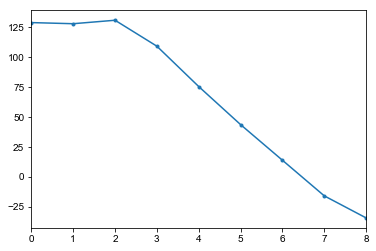

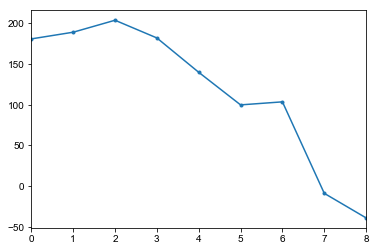

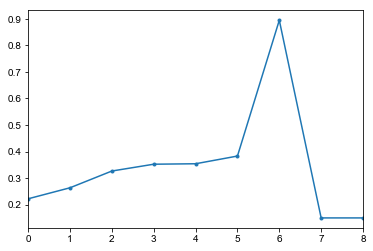

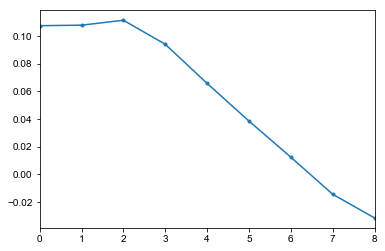

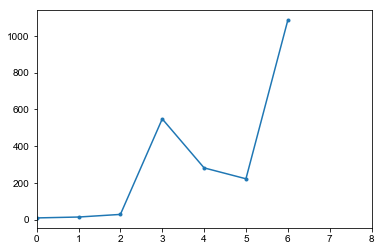

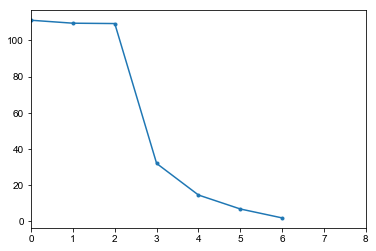

In [28]:
for name in trends:
    plt.figure()
    trends[name].plot(style='.-')
plt.show()

### Step Two: Parameter sweep on output, optimize cost

First, let's create a data structure to store the results.

In [8]:
q_fraction_range = [1, 0.95, 0.9, 0.8, 0.5, 0.2, 0.1]

In [29]:
opts2 = pandas.DataFrame(index=pandas.MultiIndex.from_product([t_heat_reject_range,
                                                               q_fraction_range],
                                                             names=['T_r','q_frac']),
                        columns=['Q','opt'])

Draw in the results from step one. (TODO: re-arrange all this...)

In [ ]:
for tr,opt in zip(t_heat_reject_range, opts):
    opts2.opt[(tr,1)] = opt
    ch = system_aqua1.makeChiller(opt.x)
    opts2.loc[(tr,1),'Q'] = ch.Q_evap
    # TODO: Would like to add constraints, eventually

In [33]:
#opts2 = opts2.append(pandas.DataFrame(columns=trendnames))

In [61]:
opts2

Q      Q_evap       Q_gen      UA_abs    UA_cond  \
T_r    q_frac                                                              
293.15 1.00    128.977391  139.030979  224.152493   11.212531  13.804200   
       0.95           NaN  122.506918  198.160173    9.383314  11.439602   
       0.90           NaN  116.083945  187.718626    8.712479  10.539891   
       0.80           NaN  103.182068  167.087555    7.498749   9.106962   
       0.50           NaN   64.490906  104.862444    4.231820   5.196822   
       0.20           NaN   25.799808   41.759857    1.563582   1.941573   
       0.10           NaN   17.842693   30.800730    1.073663   1.225104   
298.15 1.00    128.034153  139.030979  224.152493   15.268645  30.220725   
       0.95           NaN  121.655511  196.452285   12.452582  22.770665   
       0.90           NaN  115.233004  186.403077   11.478880  20.500358   
       0.80           NaN  102.405130  165.817912    9.774421  16.693889   
       0.50           NaN   64.002275  103.985507    5.382171   8.802706   
       0.20           NaN   25.618329   41.429030    1.962857   3.139382   
       0.10           NaN   17.751018   30.679645    1.318054   1.828488   
303.15 1.00    130.942300  130.942300  203.987565  104.221454  38.686949   
       0.95    124.451715  124.451716  193.940083   86.377397  33.711404   
       0.90    117.855021  117.855022  183.646335   76.554374  29.769247   
       0.80    104.780666  104.780668  163.377523   57.573899  23.425641   
       0.50     65.512974   65.512975  102.059082   27.971749  11.496224   
       0.20     30.412309   30.412309   51.314142    3.572836   3.352402   
       0.10     29.742362   29.742362   50.548689    3.436886   3.174589   
308.15 1.00    109.223406  109.223404  182.204157   30.296029  25.019476   
       0.95    103.762507  103.762509  173.702257   27.173849  22.390108   
       0.90     98.332911   98.332909  164.672612   24.885956  20.066850   
       0.80     87.379293   87.379291  146.331308   20.578919  17.005955   
       0.50     54.606523   54.606522   91.526748   10.780052   8.791664   
       0.20     23.135887   23.135887   42.082969    2.691490   2.543615   
       0.10     21.260266   21.260266   39.566782    2.446773   2.224862   
313.15 1.00     75.440689   75.440691  139.941919   14.502956  13.552586   
       0.95     71.648109   71.648108  133.270216   13.531499  12.515433   
...                   ...         ...         ...         ...        ...   
       0.20     15.088184   15.088184   31.202698    2.345508   1.643769   
       0.10     10.127537   10.127538   24.290818    1.722941   0.999226   
318.15 1.00     43.589004   43.589001   99.844678   12.132332   6.672292   
       0.95     41.411822   41.411819   95.244838   11.372001   6.279894   
       0.90     39.220209   39.220213   90.221050   10.670238   5.861557   
       0.80     34.872982   34.872981   79.977976    9.079302   5.163481   
       0.50     21.794788   21.794787   49.885074    5.174484   3.063267   
       0.20      8.717616    8.717616   22.243496    2.110073   1.076134   
       0.10      4.358804    4.358804   15.797190    1.506274   0.445596   
323.15 1.00     13.745885   13.745886  103.581624   26.707226   1.921627   
       0.95      2.562008    2.562007   27.935285    4.181383   0.333417   
       0.90      2.562080    2.562081   27.925857    4.179723   0.333429   
       0.80      4.134768    4.134767   40.844280    6.503261   0.541400   
       0.50      6.874225    6.874225   50.113964    8.248145   0.952594   
       0.20      2.748488    2.748490   25.211171    3.707146   0.365871   
       0.10      1.374703    1.374704   17.299685    2.492995   0.178903   
328.15 1.00    -16.075082  -16.075082   -8.981001         NaN        NaN   
       0.95           NaN  -16.075082   -8.981001         NaN        NaN   
       0.90           NaN  -16.075082   -8.981001         NaN        NaN   
       0.80           NaN  -16.075082   -8.981001         NaN        NaN

In [48]:
opts2.iloc[0].opt

{'fun': -128.97739149780878,
 'maxcv': 0.0,
 'message': 'Maximum number of function evaluations has been exceeded.',
 'nfev': 50,
 'status': 2,
 'success': False,
 'x': array([  2.22135233e-01,   2.78663623e+02,   3.00414681e+02,
          3.00720643e+02,   2.98714953e+02,   3.95118642e+02])}

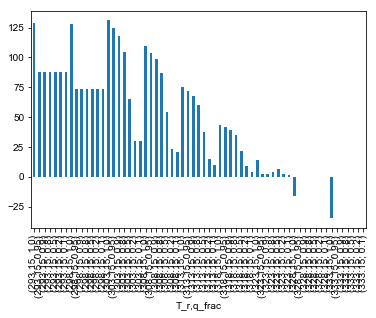

In [54]:
opts2.Q.plot.bar()
plt.show()

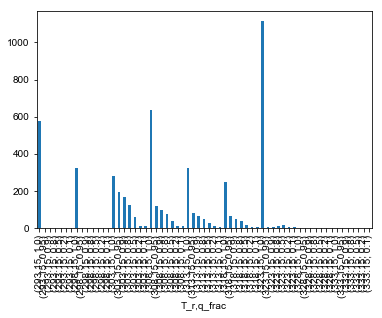

In [55]:
opts2.UA_total.plot.bar()
plt.show()

In [10]:
fname = 'optimize_trials2_5_data.csv'
if False:
    opts2.to_csv(fname)
if False:
    opts2 = pandas.read_csv(fname, header=0, index_col=[0,1])
if False:
    # If all the opt entries are __repr__ output from OptimizeResult (oops)
    from util import optimize_result_repr_to_dict
    for i,o in opts2.opt.items():
        d = optimize_result_repr_to_dict(o)
        opts2.opt[i] = d
if False:
    # If all the opt entries are strings as read by read_csv
    from numpy import array, inf, nan
    for i,o in opts2.opt.items():
        d = eval(o)
        opts2.opt[i] = d


In [47]:
dry_run = True
for i,index in enumerate(opts2.index):
    tr,qf = index
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    if opts2.opt[index] is numpy.nan or opts2.opt[index] is None:
        xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_B(bdry,q_goal)
        x = numpy.array([0.05, 278.45, tr+7, tr+8, tr+5, 395.15])
        
        if not dry_run:
            P.n_calls = 7*30
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            print("First pass and we have this ... ")
            display_result(x)

            P.n_calls = 7*40
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            print("Second pass and we have this ... ")
            display_result(x)

            P.n_calls = 7*50
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.01})
            x = opt.x
            print("Third pass and we have this ... ")
            display_result(x)

            opts2.opt[index] = opt
        

Case 0, T_heat_reject = 293.15 K, Q_fraction = 1.0, Q_goal = 128.977391498
Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.95, Q_goal = 122.5285219231
Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.9, Q_goal = 116.0796523482
Case 3, T_heat_reject = 293.15 K, Q_fraction = 0.8, Q_goal = 103.18191319840001
Case 4, T_heat_reject = 293.15 K, Q_fraction = 0.5, Q_goal = 64.488695749
Case 5, T_heat_reject = 293.15 K, Q_fraction = 0.2, Q_goal = 25.795478299600003
Case 6, T_heat_reject = 293.15 K, Q_fraction = 0.1, Q_goal = 12.897739149800001
Case 7, T_heat_reject = 298.15 K, Q_fraction = 1.0, Q_goal = 128.034152931
Case 8, T_heat_reject = 298.15 K, Q_fraction = 0.95, Q_goal = 121.63244528444999
Case 9, T_heat_reject = 298.15 K, Q_fraction = 0.9, Q_goal = 115.23073763789999
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.8, Q_goal = 102.4273223448
Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.5, Q_goal = 64.0170764655
Case 12, T_heat_reject = 298.15 K, Q_fraction = 0.2, Q_goal = 25.6068

In [58]:
dry_run = True
for i,index in enumerate(opts2.index):
    tr,qf = index
    if tr > 299:
        continue
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    if opts2.opt[index] is numpy.nan or opts2.opt[index] is None:
        xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_B(bdry,q_goal)
        x = opts2.opt[(tr,1)]['x'].copy()
        print("Initial x = ")
        display(x)
        
        if not dry_run:
            print("Running first pass optimization ... ")
            P.n_calls = 7*10
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            display_result(x)

            print("Running second pass optimization ... ")
            P.n_calls = 7*30
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            display_result(x)

            print("Running third pass optimization ... ")
            P.n_calls = 7*50
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.01})
            x = opt.x
            display_result(x)

            opts2.at[index,'opt'] = dict(opt)
    
    if not isinstance(opts2.opt[index],dict):
        opts2.at[index,'opt'] = dict(opts2.opt[index])

Case 0, T_heat_reject = 293.15 K, Q_fraction = 1.0, Q_goal = 128.977391498
Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.95, Q_goal = 122.5285219231
Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.9, Q_goal = 116.0796523482
Case 3, T_heat_reject = 293.15 K, Q_fraction = 0.8, Q_goal = 103.18191319840001
Case 4, T_heat_reject = 293.15 K, Q_fraction = 0.5, Q_goal = 64.488695749
Case 5, T_heat_reject = 293.15 K, Q_fraction = 0.2, Q_goal = 25.795478299600003
Case 6, T_heat_reject = 293.15 K, Q_fraction = 0.1, Q_goal = 12.897739149800001
Case 7, T_heat_reject = 298.15 K, Q_fraction = 1.0, Q_goal = 128.034152931
Case 8, T_heat_reject = 298.15 K, Q_fraction = 0.95, Q_goal = 121.63244528444999
Case 9, T_heat_reject = 298.15 K, Q_fraction = 0.9, Q_goal = 115.23073763789999
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.8, Q_goal = 102.4273223448
Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.5, Q_goal = 64.0170764655
Case 12, T_heat_reject = 298.15 K, Q_fraction = 0.2, Q_goal = 25.6068

In [60]:
# Post-processing

dry_run = False
for i,index in enumerate(opts2.index):
    tr,qf = index
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
    bdry = system_aqua1.makeBoundary(xB)
    if opts2.opt[index] is not numpy.nan:
        x = opts2.opt[index]['x']
        try:
            if not dry_run:
                ch = system_aqua1.makeChiller(x)

                opts2.Q_evap[index] = ch.Q_evap
                opts2.Q_gen[index] = ch.Q_gen
                opts2.m_rich[index] = ch.m_rich
                opts2.m_refrig[index] = ch.m_refrig
        
                sys = system_aqua1.System(bdry, ch)        

                opts2.UA_gen[index] = sys.df.UA['gen']
                opts2.UA_cond[index] = sys.df.UA['cond']
                opts2.UA_abs[index] = sys.df.UA['abs']
                opts2.UA_rect[index] = sys.df.UA['rect']
                opts2.UA_evap[index] = sys.df.UA['evap']
                opts2.UA_total[index] = sys.totalUA
        
        except KeyboardInterrupt:
            raise
        except:
            pass

Case 0, T_heat_reject = 293.15 K, Q_fraction = 1.0, Q_goal = 128.977391498


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWar

Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.95, Q_goal = 122.5285219231
Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.9, Q_goal = 116.0796523482
Case 3, T_heat_reject = 293.15 K, Q_fraction = 0.8, Q_goal = 103.18191319840001
Case 4, T_heat_reject = 293.15 K, Q_fraction = 0.5, Q_goal = 64.488695749
Case 5, T_heat_reject = 293.15 K, Q_fraction = 0.2, Q_goal = 25.795478299600003
Case 6, T_heat_reject = 293.15 K, Q_fraction = 0.1, Q_goal = 12.897739149800001
Case 7, T_heat_reject = 298.15 K, Q_fraction = 1.0, Q_goal = 128.034152931
Case 8, T_heat_reject = 298.15 K, Q_fraction = 0.95, Q_goal = 121.63244528444999
Case 9, T_heat_reject = 298.15 K, Q_fraction = 0.9, Q_goal = 115.23073763789999
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.8, Q_goal = 102.4273223448
Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.5, Q_goal = 64.0170764655
Case 12, T_heat_reject = 298.15 K, Q_fraction = 0.2, Q_goal = 25.6068305862
Case 13, T_heat_reject = 298.15 K, Q_fraction = 0.1, Q_goal = 12.803

## Results and plots and things

In [12]:
display(t_heat_reject_range,q_fraction_range, opts2.head())

array([ 293.15,  298.15,  303.15,  308.15,  313.15,  318.15,  323.15,
        328.15,  333.15])

[1, 0.95, 0.9, 0.8, 0.5, 0.2, 0.1]

### Q vs UA, for each heat reject temperature

<IPython.core.display.Javascript object>


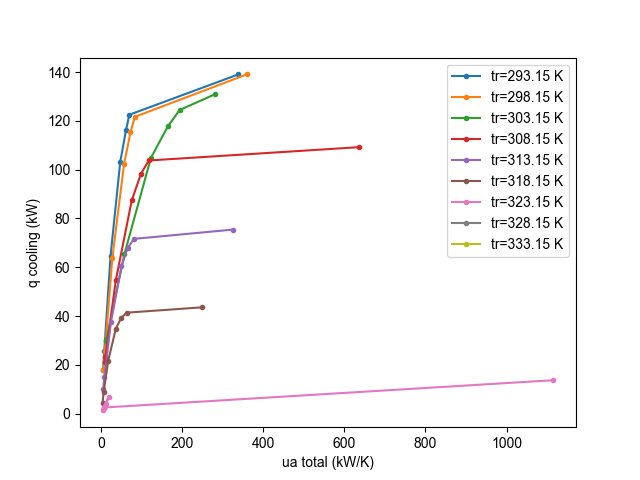

In [67]:
plt.figure()
plt.xlabel('ua total (kW/K)')
plt.ylabel('q cooling (kW)')
for t in t_heat_reject_range:
    plt.plot(opts2.UA_total[t], opts2.Q_evap[t], '.-', label="tr={} K".format(t))
plt.legend()
plt.show()

### Cooling vs Heat Reject Temperature, for each fraction of max

This doesn't have much meaning since the series are relative.

In [17]:
# Group by second index
opts3 = opts2.swaplevel()

<IPython.core.display.Javascript object>


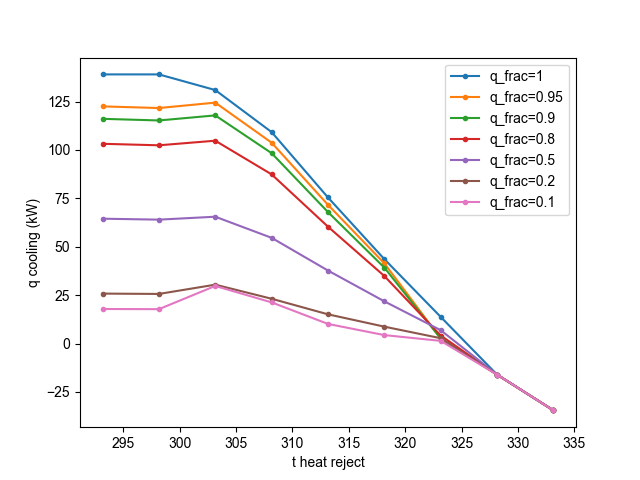

In [72]:
plt.figure()
plt.xlabel('t heat reject')
plt.ylabel('q cooling (kW)')
for q_frac in q_fraction_range:
    plt.plot(t_heat_reject_range, opts3.Q_evap[q_frac], '.-', label="q_frac={}".format(q_frac))
plt.legend()
plt.show()

### 3D plot of (T,UA,Q) with full extent of data

<IPython.core.display.Javascript object>


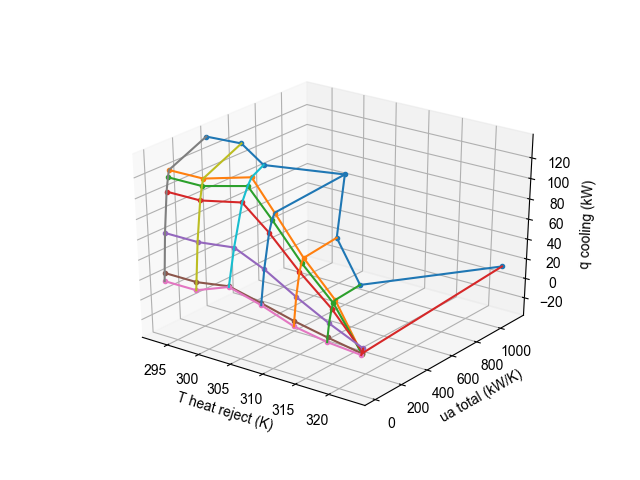

In [73]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('T heat reject (K)')
ax.set_ylabel('ua total (kW/K)')
ax.set_zlabel('q cooling (kW)')
for q_frac in q_fraction_range:
    ax.plot(t_heat_reject_range,
            array(opts3.UA_total[q_frac]),
            array(opts3.Q_evap[q_frac]),
            '.-')
for t in t_heat_reject_range:
    x = t * numpy.ones_like(q_fraction_range)
    ax.plot(x,
            array(opts2.UA_total[t]),
            array(opts2.Q_evap[t]))
#plt.ylim(0,200)
plt.show()

### Cropped 3D wireframe plot

<IPython.core.display.Javascript object>


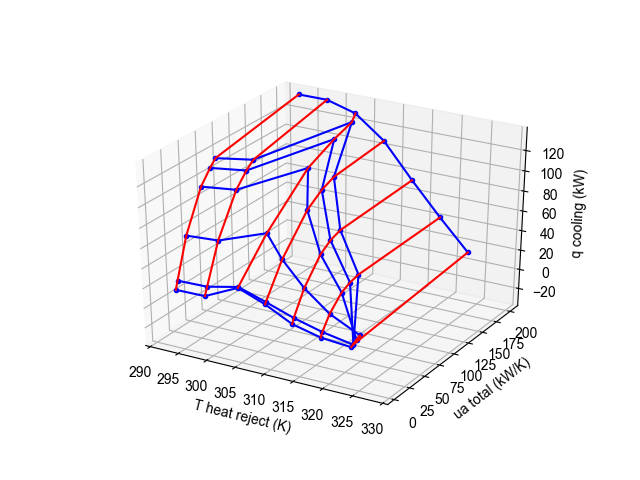

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


In [19]:
# Zoom to relevant data, say, UA < 200
# 3d plot does not handle axis limits well, so instead
# we just need to mask off that data.

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('T heat reject (K)')
ax.set_ylabel('ua total (kW/K)')
ax.set_zlabel('q cooling (kW)')
#ax.plot(t_heat_reject_range,
#        array(opts3.Q_evap[1.0]),
#        zs=200,
#        zdir='y')
#for q_frac in q_fraction_range[1:]:
for q_frac in q_fraction_range:
    x,y,z = (t_heat_reject_range.copy(),
            array(opts3.UA_total[q_frac]),
            array(opts3.Q_evap[q_frac]))
    mask = y > 200.
    #x[mask] = nan
    y[mask] = 200
    #z[mask] = nan
    ax.plot(x,y,z,'b.-')
#ax.plot(array(opts2.UA_total[293.15])[1:],
#        array(opts2.Q_evap[293.15])[1:],
#        zs=293,
#        zdir='x')
for t in t_heat_reject_range:
    x,y,z = (t * numpy.ones_like(q_fraction_range),
            array(opts2.UA_total[t]),
            array(opts2.Q_evap[t]))
    mask = y > 200.
    #x[mask] = nan
    y[mask] = 200
    #z[mask] = nan
    ax.plot(x,y,z,'r')
ax.set_xlim(290,330)
plt.show()

### Spline things up a bit

<IPython.core.display.Javascript object>


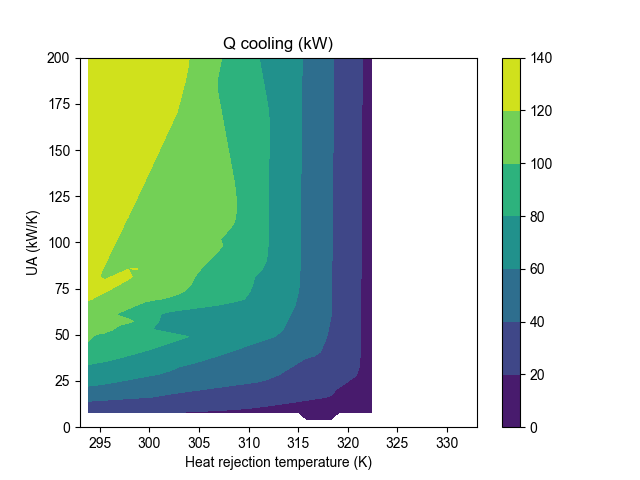

In [89]:
import scipy.interpolate
x,y,z = (array([tr for (tr,q_frac) in opts2.index]),
         array(opts2.UA_total),
         array(opts2.Q_evap))
X,Y=numpy.meshgrid(numpy.linspace(293,333),numpy.linspace(0,200))
mask = numpy.logical_not(numpy.isnan(y))
x = x[mask]
y = y[mask]
z = z[mask]
#q_of_t_ua = scipy.interpolate.SmoothBivariateSpline(x,y,z)
#q_of_t_ua = scipy.interpolate.interp2d(x,y,z)
#q_of_t_ua = scipy.interpolate.LSQBivariateSpline(x,y,z,[1,1,1,1,1],[1,1,1,1,1])
#Z=q_of_t_ua(X,Y)
#spline = scipy.interpolate.bisplrep(x,y,z)
Z = scipy.interpolate.griddata(numpy.array([x,y]).T,z,(X,Y))
plt.figure()
plt.xlabel('Heat rejection temperature (K)')
plt.ylabel('UA (kW/K)')
plt.title('Q cooling (kW)')
plt.contourf(X,Y,Z)
plt.colorbar()
plt.show()

### Bubble/color plot

<IPython.core.display.Javascript object>


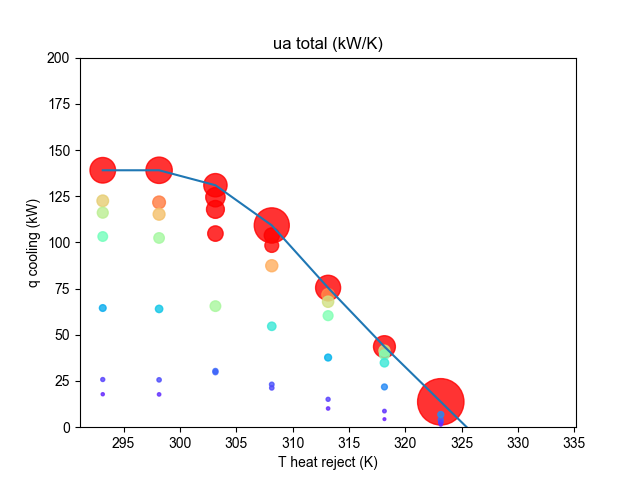

In [148]:
# Zoom to relevant data, say, set any UA over threshold to threshold (200)

fig = plt.figure()
plt.xlabel('T heat reject (K)')
plt.ylabel('q cooling (kW)')
plt.title('ua total (kW/K)')
x,y,z = ([tr for (tr,q_frac) in opts2.index],
         array(opts2.Q_evap),
         array(opts2.UA_total))
plt.scatter(x,y,c=z,vmin=0,vmax=100,cmap='rainbow',s=z,alpha=0.8)
plt.plot(t_heat_reject_range, opts3.Q_evap[1.0])
plt.ylim(0,200)
plt.show()

import scipy.interpolate

<IPython.core.display.Javascript object>


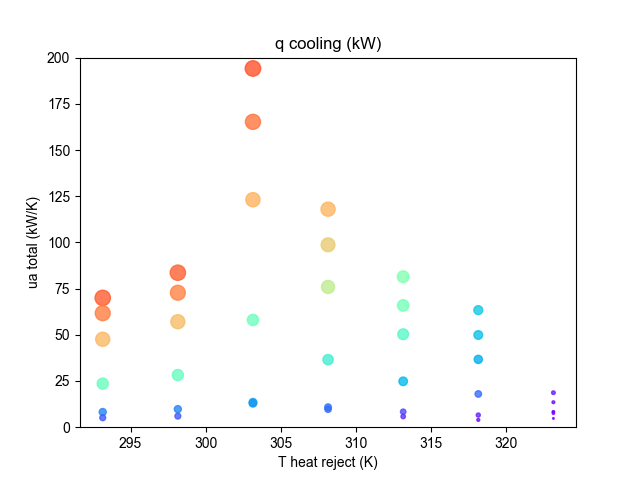

In [150]:
# Zoom to relevant data, say, set any UA over threshold to threshold (200)
matplotlib.cm
fig = plt.figure()
plt.xlabel('T heat reject (K)')
plt.ylabel('ua total (kW/K)')
plt.title('q cooling (kW)')
x,y,z = ([tr for (tr,q_frac) in opts2.index],
         array(opts2.UA_total),
         array(opts2.Q_evap))
plt.scatter(x,y,c=z,cmap='rainbow',s=z,alpha=0.8)
plt.ylim(0,200)
plt.show()

In [1]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').filter(":has(a)").map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>